# 数据分析要求

<a href="## 对数据集进行处理，转换成适合进行关联规则挖掘的形式"> - 对数据集进行处理，转换成适合进行关联规则挖掘的形式</a>

<a href="## 找出频繁模式">- 找出频繁模式</a>

<a href="## 导出关联规则，计算其支持度和置信度">- 导出关联规则，计算其支持度和置信度</a>

<a href="## 对规则进行评价 ">- 对规则进行评价，可使用Lift、卡方和其它教材中提及的指标, 至少2种</a>

<a href="## 对挖掘结果进行分析">- 对挖掘结果进行分析</a>

<a href="## 可视化展示">- 可视化展示</a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import copy

## 对数据集进行处理，转换成适合进行关联规则挖掘的形式

In [2]:
data_filename="D:\Course\DM\wine-reviews\winemag-data_first150k.csv"
dt=pd.read_csv(data_filename)

In [3]:
# 删除同时存在两个空值的记录
# 对point空值进行填充
dt=dt.dropna(thresh=9)
#dt=dt.sort_values(by="points",ascending=False)
#dt['points']=dt['points'].fillna(axis=0,method='ffill')

In [4]:
# 根据四分位对数值数据进行离散化
bins = [dt['points'].quantile(0),dt['points'].quantile(0.25),dt['points'].quantile(0.5),dt['points'].quantile(0.75),dt['points'].quantile(1)+1]
labels=['pt1','pt2','pt3','pt4']
dt['points']=pd.cut(dt.points,bins=bins,labels=labels)
bins = [dt['price'].quantile(0),dt['price'].quantile(0.25),dt['price'].quantile(0.5),dt['price'].quantile(0.75),dt['price'].quantile(0.95),dt['price'].quantile(1)+1]
labels=['pr1','pr2','pr3','pr4','pr5']
dt['price']=pd.cut(dt.price,bins=bins,labels=labels)

In [5]:
#description和winery列基本都不同，不进行分析
dt=dt.drop(['description','winery','Unnamed: 0'],axis=1)
dt = pd.DataFrame(dt, dtype='object');

## 找出频繁模式

In [6]:
dt=dt.fillna(value='nan')
train_data = np.array(dt)#np.ndarray()
l_data=train_data.tolist()#list
l_data2=list()
for item in l_data:
    item=[i for i in item if i!='nan']
    l_data2.append(item)

In [7]:
# item 的全部子集
def PowerSetsBinary(items):
    #generate all combination of N items
    N = len(items)
    #enumerate the 2**N possible combinations
    for i in range(2**N):
        combo = []
        for j in range(N):
            #test jth bit of integer i
            if(i >> j ) % 2 == 1:
                combo.append(items[j])
        yield combo
# 构建初始候选项集的列表
def createC1(dataSet):
    C1 = []
    for transaction in dataSet:
        for item in transaction:
            if [item] not in C1:
                C1.append([item])
    C1.sort()
    # return map( frozenset, C1 )
    # return [var for var in map(frozenset,C1)]
    return [frozenset(var) for var in C1]

# 扫描数据集，计算支持度
def scanDataSet(D, Ck, minSupport):
    subSetCount = {}
    for tid in D:
        for can in Ck:
            # 检查候选k项集中的每一项的所有元素是否都出现在每一个事务中，若true，则加1
            if can.issubset(tid):
                subSetCount[can] = subSetCount.get(can, 0) + 1
    numItems = float(len(D))
    returnList = []
    supportData = {}
    for key in subSetCount:
        support = subSetCount[key] / numItems  # 支持度计算
        if support >= minSupport:  # 将满足最小支持度的项集，加入returnList
            returnList.insert(0, key)
        supportData[key] = support  
    return returnList, supportData

# Aprior算法 k表示生成的新项集中所含有的元素个数
def aprioriGen(Lk, k):         
    returnList = []
    for i in range(len(Lk)):
        L1 = list(Lk[i])[: k - 2]
        for j in range(i + 1, len(Lk)):
            # 只需取前k-2个元素相等的候选频繁项集即可组成元素个数为k+1的候选频繁项集
            L2 = list(Lk[j])[: k - 2]
            L1.sort()
            L2.sort()
            if L1 == L2:
                returnList.append(Lk[i] | Lk[j])

    return returnList

def has_infrequent_subset(L, Ck, k):
    Ckc = copy.deepcopy(Ck)
    for i in Ck:
        p = [t for t in i]
        i_subset = PowerSetsBinary(p)
        subsets = [i for i in i_subset]
        for each in subsets:
            if each!=[] and each!=p and len(each)<k:
                if frozenset(each) not in [t for z in L for t in z]:
                    Ckc.remove(i)
                    break
    return Ckc


def apriori(dataSet, minSupport):
    C1 = createC1(dataSet)
    D = [set(var) for var in dataSet]
    L1, suppData = scanDataSet(D, C1, minSupport)
    L = [L1]
    k = 2

    while (len(L[k - 2]) > 0):
        Ck = aprioriGen(L[k - 2], k)
        # 剪枝
        Ck2 = has_infrequent_subset(L, Ck, k)
        Lk, supK = scanDataSet(D, Ck2, minSupport)
        suppData.update(supK)
        # 将符合最小支持度要求的项集加入L
        L.append(Lk)
        k += 1
    return L[:-1], suppData


#获取频繁项，其中，最小支持度设置为0.15
L, suppData = apriori(l_data2, 0.15)
print("频繁项集L：", L)

频繁项集L： [[frozenset({'pt2'}), frozenset({'pt1'}), frozenset({'pr3'}), frozenset({'pt3'}), frozenset({'pr1'}), frozenset({'pr2'}), frozenset({'Italy'}), frozenset({'pr4'}), frozenset({'pt4'}), frozenset({'US'}), frozenset({'California'})], [frozenset({'US', 'pt1'}), frozenset({'pt1', 'pr1'}), frozenset({'US', 'California'})]]


In [8]:
#根据支持度大小，取前40个记录
df = pd.DataFrame.from_dict(suppData,orient='index',columns=['支持度'])
df = df.reset_index().rename(columns = {'index':'频繁项集'})
df=df.sort_values(by="支持度",ascending=False)
df=df.head(40)
df

,频繁项集,支持度
5,(US),0.444022
188,(pt1),0.330179
32118,"(US, California)",0.316961
1,(California),0.316961
334,(pt2),0.254214
85,(pr1),0.252576
60,(pr2),0.251116
7,(pt4),0.218977
89,(pr3),0.215267
86,(pt3),0.190627


## 导出关联规则，计算其支持度和置信度

In [9]:
from pymining import itemmining, assocrules

In [10]:
#获取关联规则，最小支持度选取0.15，最小置信度选区0.05
rules1=assocrules.mine_assoc_rules(suppData,min_support=0.05,min_confidence=0.05)

In [11]:
#展示结果
df=pd.DataFrame(rules1)
df.columns = ['LHS','RHS','Support','Confidence']
df

,LHS,RHS,Support,Confidence
0,(pt4),(US),0.102741,0.469186
1,(US),(pt4),0.102741,0.231387
2,(California),(pt4),0.074077,0.233711
3,(pt4),(California),0.074077,0.338287
4,(California),(US),0.316961,1.000000
5,(US),(California),0.316961,0.713841
6,(pr4),(pt4),0.086013,0.491735
7,(pt4),(pr4),0.086013,0.392793
8,(pr4),(US),0.095207,0.544296
9,(US),(pr4),0.095207,0.214419


## 对规则进行评价
 选用Lift、全置信度，最大置信度，Kulczynsky度量和余弦度量

In [12]:
df['lift']=None
df['all_conf']=None
df['max_conf']=None
df['Kulc']=None
df['cosine']=None


In [13]:
for i in range(len(df)):
    df.loc[i,'lift']=df.loc[i,'Confidence']/suppData[df.loc[i,'RHS']]
    j=df[(df['RHS']==df.loc[i,'LHS']) &( df['LHS']==df.loc[i,'RHS'] )].index.tolist()[0]
    df.loc[i,'all_conf']=min(df.loc[i,'Confidence'],df.loc[j,'Confidence'])
    df.loc[i,'max_conf']=max(df.loc[i,'Confidence'],df.loc[j,'Confidence'])
    df.loc[i,'Kulc']=(df.loc[i,'Confidence']+df.loc[j,'Confidence'])/2
    df.loc[i,'cosine']=(df.loc[i,'Confidence']*df.loc[j,'Confidence'])**0.5

In [14]:
df

,LHS,RHS,Support,Confidence,lift,all_conf,max_conf,Kulc,cosine
0,(pt4),(US),0.102741,0.469186,1.05667,0.231387,0.469186,0.350287,0.32949
1,(US),(pt4),0.102741,0.231387,1.05667,0.231387,0.469186,0.350287,0.32949
2,(California),(pt4),0.074077,0.233711,1.06728,0.233711,0.338287,0.285999,0.281179
3,(pt4),(California),0.074077,0.338287,1.06728,0.233711,0.338287,0.285999,0.281179
4,(California),(US),0.316961,1.000000,2.25214,0.713841,1,0.856921,0.844891
5,(US),(California),0.316961,0.713841,2.25214,0.713841,1,0.856921,0.844891
6,(pr4),(pt4),0.086013,0.491735,2.2456,0.392793,0.491735,0.442264,0.439489
7,(pt4),(pr4),0.086013,0.392793,2.2456,0.392793,0.491735,0.442264,0.439489
8,(pr4),(US),0.095207,0.544296,1.22583,0.214419,0.544296,0.379357,0.341624
9,(US),(pr4),0.095207,0.214419,1.22583,0.214419,0.544296,0.379357,0.341624


## 对挖掘结果进行分析
选取部分规则进行分析
由第0、3条规则可以分析得到，红酒评分在pt4范围内的，在美国California生产的可能性的较大。

如第6条规则 (pt4)->(pr4),提升度>1，说明pt4和pr4 呈正相关的关系，评分在pt4范围的红酒价格处于pr4范围内。




## 可视化展示
使用散列图对关联规则进行展示，横坐标为支持度，纵坐标为置信度

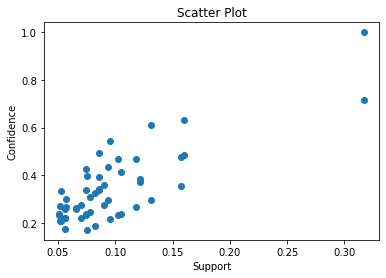

In [15]:
import matplotlib.pyplot as plt
fig=plt.figure()
ax1=fig.add_subplot(1,1,1)
ax1.set_title("Scatter Plot")
ax1.set_xlabel("Support")
ax1.set_ylabel("Confidence")
ax1.scatter(df['Support'],df['Confidence'])